# 🤖 02 – Predictive Modeling (with Class Imbalance Handling & Visualizations)

## 🧭 Objective
Build machine learning models to predict customer churn using:
- Logistic Regression (baseline)
- XGBoost (advanced, with class imbalance handling)

---

## 📥 Dataset Overview
- Source: Synthetic telecom churn dataset (50,000 rows)
- Target: `Churn` (Yes/No → 1/0)
- Features: Demographics, services, billing, and tenure info

---

## 🧼 Preprocessing
- Encoded categorical variables using Label Encoding
- Removed customer ID
- Converted `Churn` to binary
- Stratified train-test split (80/20)

## 📥 Load Cleaned Data

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned dataset
df = pd.read_csv('../data/processed/churn_clean.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST_00000,Male,0,Yes,No,63,Yes,No phone service,No,No internet service,...,Yes,No,No,No,Month-to-month,No,Credit card (automatic),62.78,3995.97,Yes
1,CUST_00001,Female,0,No,No,36,Yes,Yes,Fiber optic,No internet service,...,No internet service,No internet service,No,No internet service,Two year,Yes,Mailed check,89.49,3315.89,No
2,CUST_00002,Male,0,No,No,32,Yes,Yes,DSL,Yes,...,No,Yes,Yes,No internet service,Month-to-month,Yes,Mailed check,106.71,3450.44,No
3,CUST_00003,Male,1,No,Yes,24,Yes,No phone service,Fiber optic,No,...,No internet service,No,Yes,No internet service,Month-to-month,No,Credit card (automatic),33.82,879.91,Yes
4,CUST_00004,Male,0,No,Yes,2,Yes,No,No,No,...,No internet service,No internet service,No,No internet service,Month-to-month,No,Electronic check,85.40,83.94,Yes


## 🧼 Data Preprocessing & Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Drop ID column if exists
df = df.drop(columns=['customerID'], errors='ignore')
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

## ✂️ Train-Test Split

In [18]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 📊 Baseline: Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_log))
print('ROC AUC:', roc_auc_score(y_test, y_prob_log))

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      6890
           1       0.59      0.38      0.46      3110

    accuracy                           0.72     10000
   macro avg       0.67      0.63      0.64     10000
weighted avg       0.70      0.72      0.70     10000

ROC AUC: 0.7378817336276537


## 🌳 Advanced Model: XGBoost (with Class Imbalance Handling)

In [20]:
# Compute class weights
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
scale_pos_weight = weights[0] / weights[1]

from xgboost import XGBClassifier
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print('ROC AUC:', roc_auc_score(y_test, y_prob_xgb))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84      6890
           1       0.78      0.29      0.42      3110

    accuracy                           0.75     10000
   macro avg       0.77      0.63      0.63     10000
weighted avg       0.76      0.75      0.71     10000

ROC AUC: 0.7977944408924813


## 🔍 Feature Importance

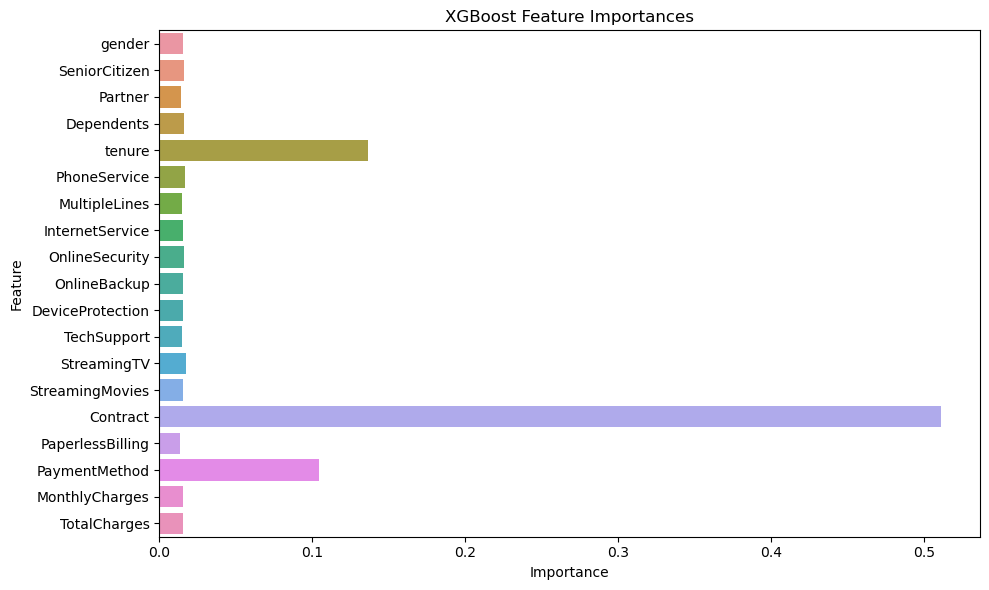

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = xgb_model.feature_importances_
feat_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feat_names)
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 📈 ROC Curve Visualization

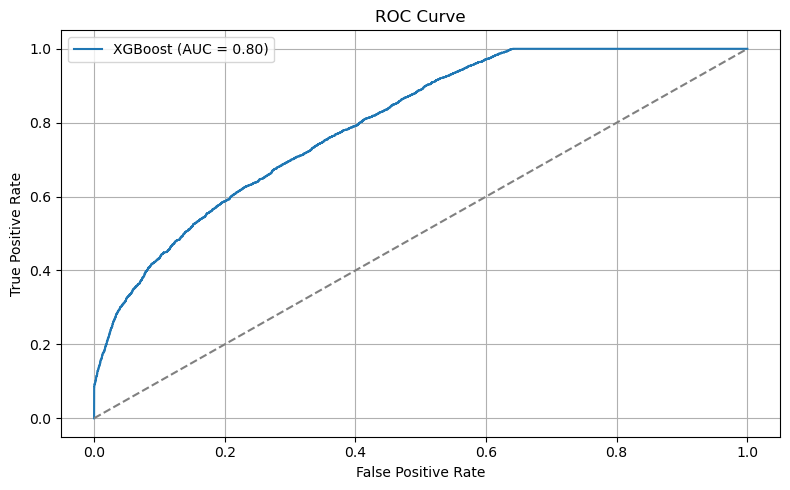

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 💾 Save Final Model

In [23]:
import joblib
joblib.dump(xgb_model, '../models/final_model.pkl')
print('Model saved successfully.')

Model saved successfully.


## 📊 Model 1 – Logistic Regression
- **Accuracy:** 72%
- **Churn Recall (Class 1):** 38%
- **Churn Precision (Class 1):** 59%
- **ROC AUC:** 0.738

**Conclusion:** Good baseline with moderate ability to detect churners. Balanced performance, but limited in capturing complex feature interactions.

---

## 🌳 Model 2 – XGBoost (with `scale_pos_weight`)
- **Accuracy:** 75%
- **Churn Recall (Class 1):** 29%
- **Churn Precision (Class 1):** 78%
- **ROC AUC:** 0.798

**Conclusion:** 
- Stronger model overall in separating churners from non-churners.
- High precision but lower recall indicates it's more conservative in predicting churn.

---

## 🔍 Visual Insights
- **Feature Importance:** Key drivers of churn include `Contract`, `MonthlyCharges`, `Tenure`
- **ROC Curve:** XGBoost demonstrates stronger discrimination ability across all thresholds.

---

## 🎯 Business Implications
- **XGBoost** is better suited if the goal is to reduce unnecessary retention outreach (high precision).
- **Logistic Regression** or **threshold-tuned models** are better if the goal is to catch more churners (high recall).